In [103]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import gaussian_kde



In [104]:
# Go to the correct working directory
while not os.getcwd().endswith('NatCo-Project'):
    os.chdir(os.path.dirname(os.getcwd()))

# Stack all the pandas dataframes
mydflist = []
for participant_dir in os.listdir(os.path.join(os.getcwd(),'data','archives','Participants')):
    if not participant_dir.endswith('gitkeep'):
        mydflist.append(pd.read_csv(os.path.join(os.getcwd(),'data','archives','Participants',participant_dir,'turingtest.csv')))
full_df = pd.concat(mydflist,axis=0)
full_df.reset_index(drop=True)

,g,name1,name2,correct_idx,selected_idx
0,g1,/Users/ron/Documents/Artificial Intelligence/M...,/Users/ron/Documents/Artificial Intelligence/M...,1,0
1,g10,/Users/ron/Documents/Artificial Intelligence/M...,/Users/ron/Documents/Artificial Intelligence/M...,0,1
2,g10,/Users/ron/Documents/Artificial Intelligence/M...,/Users/ron/Documents/Artificial Intelligence/M...,0,0
3,g10,/Users/ron/Documents/Artificial Intelligence/M...,/Users/ron/Documents/Artificial Intelligence/M...,1,0
4,g10,/Users/ron/Documents/Artificial Intelligence/M...,/Users/ron/Documents/Artificial Intelligence/M...,0,0
...,...,...,...,...,...
215,g10,/home/guus/Uni/AI_Master/Years/1/sem2/NatCo/Na...,/home/guus/Uni/AI_Master/Years/1/sem2/NatCo/Na...,1,1
216,g1,/home/guus/Uni/AI_Master/Years/1/sem2/NatCo/Na...,/home/guus/Uni/AI_Master/Years/1/sem2/NatCo/Na...,1,0
217,g10,/home/guus/Uni/AI_Master/Years/1/sem2/NatCo/Na...,/home/guus/Uni/AI_Master/Years/1/sem2/NatCo/Na...,0,1
218,g1,/home/guus/Uni/AI_Master/Years/1/sem2/NatCo/Na...,/home/guus/Uni/AI_Master/Years/1/sem2/NatCo/Na...,0,1


In [105]:
scores = 1*(np.array(full_df['correct_idx']) == np.array(full_df['selected_idx']))
g_idxs = np.array(full_df['g'])
g_idxs = np.where(g_idxs == 'g1', 0, 1)

In [106]:
full_df['correct_selection'] = full_df['correct_idx'] == full_df['selected_idx']
total_selections = len(full_df)
total_correct = full_df['correct_selection'].sum()



In [107]:
g1_df= full_df[full_df['g'] == 'g1']
total_selections_g1 = len(g1_df)
total_correct_g1 = g1_df['correct_selection'].sum()

In [108]:
g10_df= full_df[full_df['g'] == 'g10']
total_selections_g10 = len(g10_df)
total_correct_g10 = g10_df['correct_selection'].sum()

In [109]:
with pm.Model() as h0:

    alpha = pm.Constant("alpha",1)
    beta = pm.Constant("beta",1)

    theta = pm.Beta(name="theta", alpha=alpha, beta=beta)

    obs = pm.Bernoulli(name="obs",p=theta,observed = scores)

    trace_h0 = pm.sample(20000,return_inferencedata=True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [beta]
>>Metropolis: [alpha]
>NUTS: [theta]


ValueError: Not enough samples to build a trace.

array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

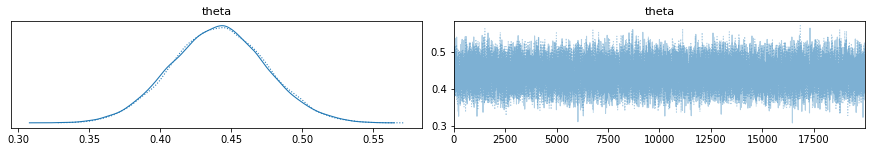

In [8]:
az.plot_trace(trace_h0, var_names="theta")

In [9]:
with pm.Model() as h1:

    alpha_g1 = pm.Constant("alpha_g1",2)
    beta_g1 = pm.Constant("beta_g1",1)

    alpha_g10 = pm.Constant("alpha_g10",1)
    beta_g10 = pm.Constant("beta_g10",1)

    theta_g1 = pm.Beta(name="theta_g1", alpha=alpha_g1, beta=beta_g1)
    theta_g10 = pm.Beta(name="theta_g10", alpha=alpha_g10, beta=beta_g10)

    phi = pm.Deterministic('phi',g_idxs*theta_g10 + (1-g_idxs)*theta_g1)

    delta = pm.Deterministic('delta',theta_g1-theta_g10)

    obs = pm.Bernoulli(name='obs',p=phi, observed=scores)
    #
    # for i,v in enumerate(scores):
    #     obs += [pm.Bernoulli(name=f'obs{i}',p=phi[i], observed=scores[i])]

    trace_h1 = pm.sample(20000,return_inferencedata=True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [beta_g10]
>>Metropolis: [alpha_g10]
>>Metropolis: [beta_g1]
>>Metropolis: [alpha_g1]
>NUTS: [theta_g10, theta_g1]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 43 seconds.
/home/guus/Uni/AI_Master/Years/1/sem2/NatCo/NatCo-Project/venv/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [10]:
compare_dict = {"h0":trace_h0,"h1":trace_h1}
df_comp_WAIC = az.compare(compare_dict,ic='LOO')

/home/guus/Uni/AI_Master/Years/1/sem2/NatCo/NatCo-Project/venv/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


In [11]:
df_comp_WAIC


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
h0,0,-151.953197,1.000666,0.000000,1.0,1.749818,0.000000,False,log
h1,1,-152.541515,2.025177,0.588318,0.0,1.872224,0.856904,False,log


In [110]:
matplotlib.rcParams['axes.labelsize'] =15
plt.rcParams["figure.figsize"] = (5,4)

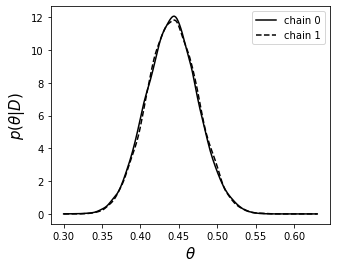

In [111]:
linestyles = ['-','--']
for i,d in enumerate(trace_h0.posterior.theta):
    density = gaussian_kde(d)
    xs = np.linspace(0.3,0.63,200)
    density.covariance_factor = lambda : .25
    plt.plot(xs,density(xs),label=f"chain {i}", c='black',linestyle=linestyles[i])
plt.legend()
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta|D)$')
plt.savefig("theta.png")
plt.show()

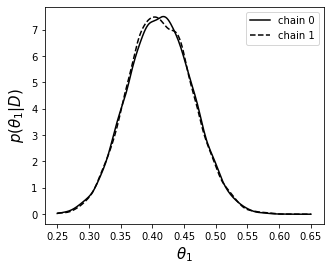

In [112]:
linestyles = ['-','--']
for i,d in enumerate(trace_h1.posterior.theta_g1):
    density = gaussian_kde(d)
    xs = np.linspace(0.25,0.65,200)
    density.covariance_factor = lambda : .25
    plt.plot(xs,density(xs),label=f"chain {i}", c='black',linestyle=linestyles[i])
plt.legend()
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$p(\theta_1|D)$')
plt.savefig("theta_g1.png")

plt.show()

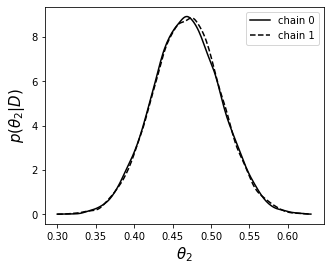

In [113]:
linestyles = ['-','--']
for i,d in enumerate(trace_h1.posterior.theta_g10):
    density = gaussian_kde(d)
    xs = np.linspace(0.3,0.63,200)
    density.covariance_factor = lambda : .25
    plt.plot(xs,density(xs),label=f"chain {i}", c='black',linestyle=linestyles[i])
plt.legend()
plt.xlabel(r'$\theta_2$')
plt.ylabel(r'$p(\theta_2|D)$')
plt.savefig("theta_g10.png")

plt.show()

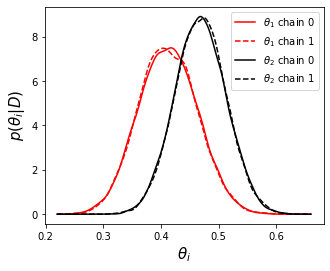

In [114]:
linestyles = ['-','--']
xs = np.linspace(0.22,0.66,200)
for i,d in enumerate(trace_h1.posterior.theta_g1):
    density = gaussian_kde(d)
    density.covariance_factor = lambda : .25
    plt.plot(xs,density(xs),label=fr"$\theta_1$ chain {i}", c='red',linestyle=linestyles[i])
for i,d in enumerate(trace_h1.posterior.theta_g10):
    density = gaussian_kde(d)
    density.covariance_factor = lambda : .25
    plt.plot(xs,density(xs),label=fr"$\theta_2$ chain {i}", c='black',linestyle=linestyles[i])

plt.legend()
plt.xlabel(r'$\theta_i$')
plt.ylabel(r'$p(\theta_i|D)$')
plt.savefig("theta_g10_g1.png")

plt.show()

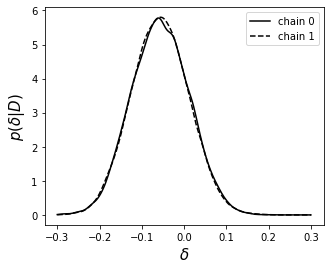

In [115]:
linestyles = ['-','--']
for i,d in enumerate(trace_h1.posterior.delta):
    density = gaussian_kde(d)
    xs = np.linspace(-0.3,0.3,200)
    density.covariance_factor = lambda : .25
    plt.plot(xs,density(xs),label=f"chain {i}", c='black',linestyle=linestyles[i])
plt.legend()
plt.xlabel(r'$\delta$')
plt.ylabel(r'$p(\delta|D)$')
plt.savefig("delta.png")
plt.show()

In [143]:

with pm.Model() as bayesfactormodel:
    p = np.array([0.5, 0.5])
    model_index = pm.Categorical(name='model_index', p=p)

    alpha = pm.Constant("alpha",1)
    beta = pm.Constant("beta",1)

    model0 = pm.Beta(name="theta", alpha=alpha, beta=beta)

    alpha_g1 = pm.Constant("alpha_g1",2)
    beta_g1 = pm.Constant("beta_g1",1)

    alpha_g10 = pm.Constant("alpha_g10",1)
    beta_g10 = pm.Constant("beta_g10",1)

    theta_g1 = pm.Beta(name="theta_g1", alpha=alpha_g1, beta=beta_g1)
    theta_g10 = pm.Beta(name="theta_g10", alpha=alpha_g10, beta=beta_g10)

    delta = pm.Deterministic('delta',theta_g1-theta_g10)
    model1 = pm.Deterministic('phi',g_idxs*theta_g10 + (1-g_idxs)*theta_g1)

    m = pm.math.switch(model_index, model0, model1)
    # pass M to a prior or likelihood, for example
    y = pm.Bernoulli(name='y', p=m, observed=scores)

    step0 = pm.ElemwiseCategorical(vars=[model_index], values=[0,1])
    step1 = pm.NUTS()
    trace = pm.sample(20000, step=[step0, step1], chains = 2, return_inferencedata=True, tune=5000)

<ipython-input-143-fed986c71f30>:26: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  step0 = pm.ElemwiseCategorical(vars=[model_index], values=[0,1])
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>ElemwiseCategorical: [model_index]
>NUTS: [theta_g10, theta_g1, theta]
>CompoundStep
>>Metropolis: [beta_g10]
>>Metropolis: [alpha_g10]
>>Metropolis: [beta_g1]
>>Metropolis: [alpha_g1]
>>Metropolis: [beta]
>>Metropolis: [alpha]


Sampling 2 chains for 5_000 tune and 20_000 draw iterations (10_000 + 40_000 draws total) took 152 seconds.
/home/guus/Uni/AI_Master/Years/1/sem2/NatCo/NatCo-Project/venv/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The acceptance probability does not match the target. It is 0.6316785844644077, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


<ipython-input-145-03b34df727ad>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)


array([[<AxesSubplot:title={'center':'model_index'}>,
        <AxesSubplot:title={'center':'model_index'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'alpha_g1'}>,
        <AxesSubplot:title={'center':'alpha_g1'}>],
       [<AxesSubplot:title={'center':'beta_g1'}>,
        <AxesSubplot:title={'center':'beta_g1'}>],
       [<AxesSubplot:title={'center':'alpha_g10'}>,
        <AxesSubplot:title={'center':'alpha_g10'}>],
       [<AxesSubplot:title={'center':'beta_g10'}>,
        <AxesSubplot:title={'center':'beta_g10'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>],
       [<AxesSubplot:title={'center':'theta_g1'}>,
        <AxesSubplot:title={'center':'theta_g1'}>],
       [<AxesSubplot:title={'center':'theta_g10'}>,
        <AxesSubplot:title={'center

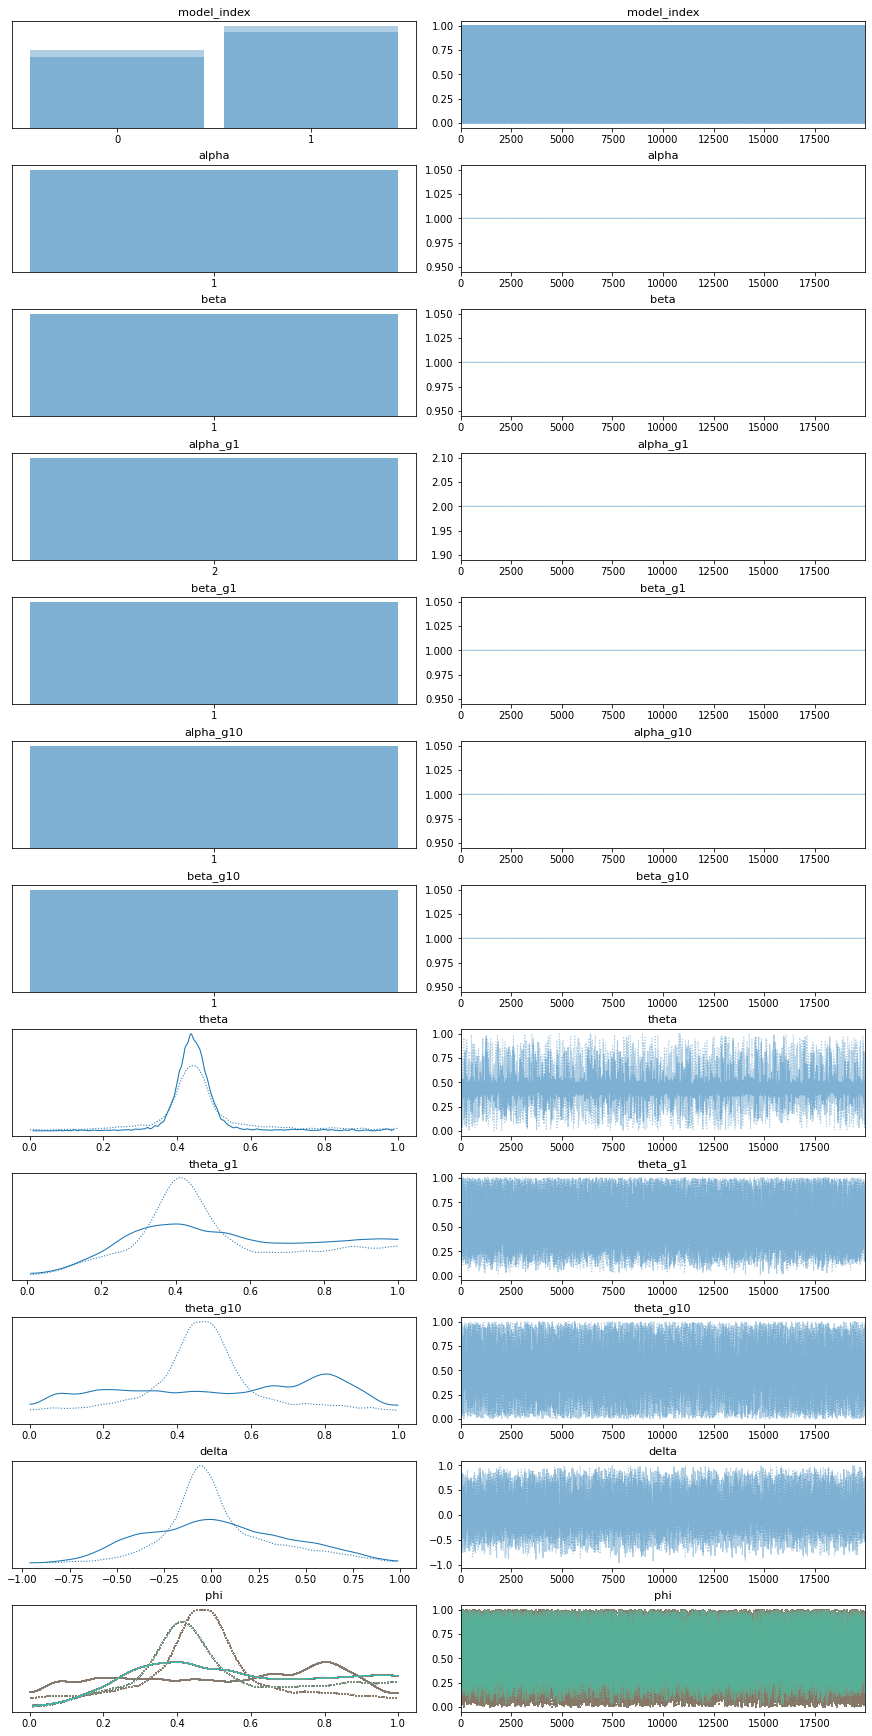

In [145]:
pm.traceplot(trace)

In [144]:
pM1 = trace.posterior['model_index'].mean()
pM0 = 1 - pM1
pM0, pM1, (pM0/pM1)*(p[1]/p[0])

(<xarray.DataArray 'model_index' ()>
 array(0.430225),
 <xarray.DataArray 'model_index' ()>
 array(0.569775),
 <xarray.DataArray 'model_index' ()>
 array(0.75507876))

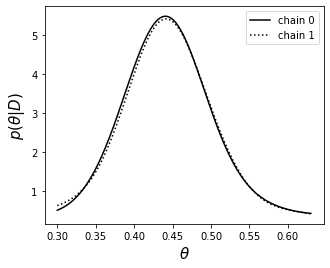

In [138]:
linestyles = ['solid','dotted','dashed','dashdot']
for i,d in enumerate(trace.posterior.theta):
    density = gaussian_kde(d)
    xs = np.linspace(0.3,0.63,200)
    density.covariance_factor = lambda : .25
    plt.plot(xs,density(xs),label=f"chain {i}", c='black',linestyle=linestyles[i])
plt.legend()
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta|D)$')
plt.savefig("theta.png")
plt.show()

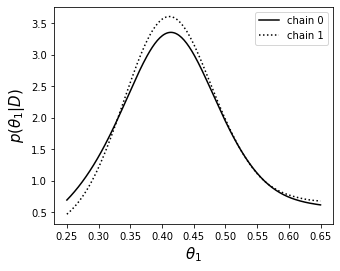

In [139]:
for i,d in enumerate(trace.posterior.theta_g1):
    density = gaussian_kde(d)
    xs = np.linspace(0.25,0.65,200)
    density.covariance_factor = lambda : .25
    plt.plot(xs,density(xs),label=f"chain {i}", c='black',linestyle=linestyles[i])
plt.legend()
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$p(\theta_1|D)$')
plt.savefig("theta_g1.png")

plt.show()

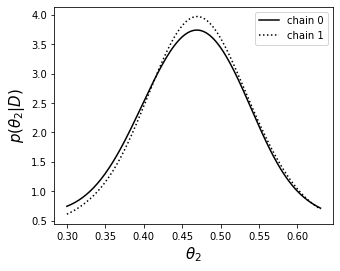

In [140]:
for i,d in enumerate(trace.posterior.theta_g10):
    density = gaussian_kde(d)
    xs = np.linspace(0.3,0.63,200)
    density.covariance_factor = lambda : .25
    plt.plot(xs,density(xs),label=f"chain {i}", c='black',linestyle=linestyles[i])
plt.legend()
plt.xlabel(r'$\theta_2$')
plt.ylabel(r'$p(\theta_2|D)$')
plt.savefig("theta_g10.png")

plt.show()

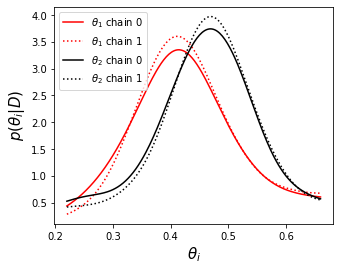

In [141]:
xs = np.linspace(0.22,0.66,200)
for i,d in enumerate(trace.posterior.theta_g1):
    density = gaussian_kde(d)
    density.covariance_factor = lambda : .25
    plt.plot(xs,density(xs),label=fr"$\theta_1$ chain {i}", c='red',linestyle=linestyles[i])
for i,d in enumerate(trace.posterior.theta_g10):
    density = gaussian_kde(d)
    density.covariance_factor = lambda : .25
    plt.plot(xs,density(xs),label=fr"$\theta_2$ chain {i}", c='black',linestyle=linestyles[i])

plt.legend()
plt.xlabel(r'$\theta_i$')
plt.ylabel(r'$p(\theta_i|D)$')
plt.savefig("theta_g10_g1.png")

plt.show()

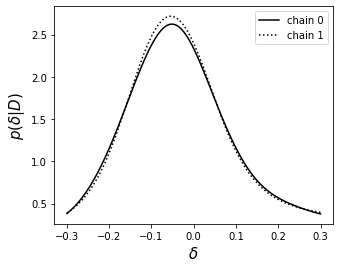

In [142]:
for i,d in enumerate(trace.posterior.delta):
    density = gaussian_kde(d)
    xs = np.linspace(-0.3,0.3,200)
    density.covariance_factor = lambda : .25
    plt.plot(xs,density(xs),label=f"chain {i}", c='black',linestyle=linestyles[i])
plt.legend()
plt.xlabel(r'$\delta$')
plt.ylabel(r'$p(\delta|D)$')
plt.savefig("delta.png")
plt.show()